<a href="https://colab.research.google.com/github/bimewok/predicting_tides/blob/main/predicting_tides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import copy
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib as mpl
import requests, io
from IPython.core.display import display 


pd.set_option('display.max_columns', None)

print('Ready to Go!')

Ready to Go!


In [17]:
file = requests.get('https://raw.githubusercontent.com/bimewok/predicting_tides/main/data/tides.csv').content
    
data = pd.read_csv(io.StringIO(file.decode('utf-8')))



data['date'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

data = data.replace({-32767: np.nan})

data = data.interpolate(method='linear')

display(data[242358:242368])

,year,month,day,hour,height,date
242358,1936.0,10.0,12.0,15.0,1370.0,1936-10-12 15:00:00
242359,1936.0,10.0,12.0,16.0,1461.0,1936-10-12 16:00:00
242360,1936.0,10.0,12.0,17.0,1674.0,1936-10-12 17:00:00
242361,1936.0,10.0,12.0,18.0,1857.0,1936-10-12 18:00:00
242362,1936.0,10.0,12.0,19.0,2040.0,1936-10-12 19:00:00
242363,1936.0,10.0,12.0,20.0,2193.0,1936-10-12 20:00:00
242364,1936.0,10.0,12.0,21.0,2315.0,1936-10-12 21:00:00
242365,1936.0,10.0,12.0,22.0,2284.0,1936-10-12 22:00:00
242366,1936.0,10.0,12.0,23.0,2162.0,1936-10-12 23:00:00
242367,1936.0,10.0,13.0,0.0,1979.0,1936-10-13 00:00:00


In [18]:
data = data.drop(['year', 'month', 'day', 'hour', 'date'], axis=1)

In [19]:
future_steps = 168
past_steps = 168
y_position = 0
train_size = 0.7

def split_df(df=data, tr_size=train_size):
    length = len(df)
    train_end = int(tr_size*length)
    val_end = int(train_end+(((1-tr_size)/2)*length))
    
    train = df.iloc[:train_end]
    val = df.iloc[train_end:val_end]
    test = df.iloc[val_end:]
    return train, test, val

train, test, val = split_df()

In [20]:
def scale_data(train=train, val=val, test=test):
    maxes = []
    
    for col in train.columns:
        maxes.append(max(train[col]))
    for i in range(len(maxes)):
        train.iloc[:,i] = train.iloc[:,i] / maxes[i]
        val.iloc[:,i] = val.iloc[:,i] / maxes[i]
        test.iloc[:,i] = test.iloc[:,i] / maxes[i]
    return train, val, test, maxes

train, val, test, maxes = scale_data()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [21]:
def reshape_data(df, y_position, past_steps, future_steps):

    y_intermediate = df.iloc[:,y_position]
    y = []
    for i in range(len(y_intermediate)):
        if i <= (len(y_intermediate) - (future_steps+1)):
            y.append(y_intermediate.iloc[i+1:i+1+(future_steps)])
            if i % 100000 == 0:
                print(round((i/len(y_intermediate))*100, 0), '%')
    df = df.head(len(y))
    num_batches = int(len(df) / past_steps)
    if num_batches*past_steps < len(y):
        y = y[:num_batches*past_steps]
        df = df.head(len(y))
        
    y = np.array(y)
    
   
    x = np.array(df)
    
    y = np.reshape(y, (num_batches,past_steps,future_steps))
    x = np.reshape(x, (num_batches,past_steps,len(df.columns)))

    return x, y
print('starting train')
x_train, y_train = reshape_data(train, y_position, past_steps, future_steps)
print('starting validation')
x_val, y_val = reshape_data(test, y_position, past_steps, future_steps)
print('starting test')
x_test, y_test = reshape_data(val, y_position, past_steps, future_steps)

0.0 %
15.0 %
30.0 %
44.0 %
59.0 %
74.0 %
89.0 %
strarting validation
0.0 %
69.0 %
strarting test
0.0 %
69.0 %


In [22]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=[None, len(train.columns)]),
    keras.layers.Dense(80),
    keras.layers.LSTM(64, return_sequences=True),
   
    keras.layers.TimeDistributed(keras.layers.Dense(future_steps))
])

model.compile(loss="mse", optimizer="adam", metrics=last_time_step_mse)
history = model.fit(x_train, y_train, epochs=15,
                    validation_data=(x_val, y_val))

Epoch 1/15
126/126 [==============================] - 5s 25ms/step - loss: 0.1079 - last_time_step_mse: 0.1048 - val_loss: 0.0301 - val_last_time_step_mse: 0.0285
Epoch 2/15
126/126 [==============================] - 2s 19ms/step - loss: 0.0246 - last_time_step_mse: 0.0224 - val_loss: 0.0167 - val_last_time_step_mse: 0.0148
Epoch 3/15
126/126 [==============================] - 2s 19ms/step - loss: 0.0156 - last_time_step_mse: 0.0136 - val_loss: 0.0153 - val_last_time_step_mse: 0.0134
Epoch 4/15
126/126 [==============================] - 2s 20ms/step - loss: 0.0132 - last_time_step_mse: 0.0113 - val_loss: 0.0120 - val_last_time_step_mse: 0.0098
Epoch 5/15
126/126 [==============================] - 2s 18ms/step - loss: 0.0102 - last_time_step_mse: 0.0077 - val_loss: 0.0079 - val_last_time_step_mse: 0.0052
Epoch 6/15
126/126 [==============================] - 2s 18ms/step - loss: 0.0072 - last_time_step_mse: 0.0044 - val_loss: 0.0069 - val_last_time_step_mse: 0.0042
Epoch 7/15
126/126 [==

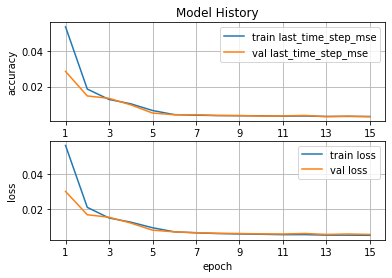

In [23]:
def plot_history(history=history):
    h = pd.DataFrame(history.history)
    h['epoch'] = h.index + 1
    
    
    plt.subplot(2, 1, 1)
    plt.plot(h['epoch'], h['last_time_step_mse'], h['epoch'], h['val_last_time_step_mse'])
    plt.title('Model History')
    plt.ylabel('Mean Squared Error - last time step')
    plt.grid(True)
    plt.legend(('train mse', 'val mse'),
               loc='upper right')
    plt.xticks(range(1,max(h['epoch'])+1, 2))
    
    
    plt.subplot(2, 1, 2)
    plt.plot(h['epoch'], h['loss'], h['epoch'], h['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend(('train loss', 'val loss'),
               loc='upper right')
    plt.xticks(range(1,max(h['epoch'])+1, 2))
    plt.show()

plot_history()



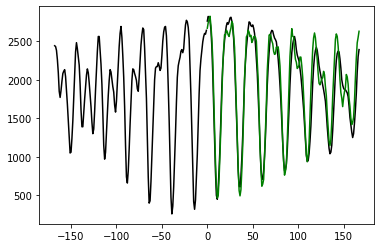

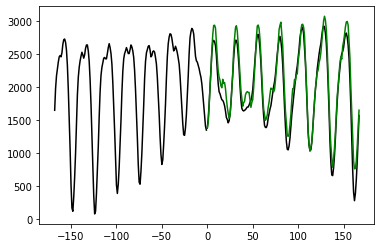

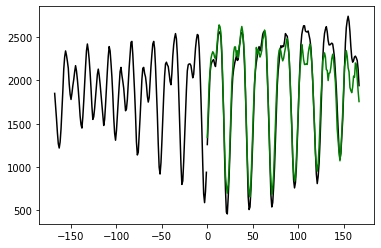

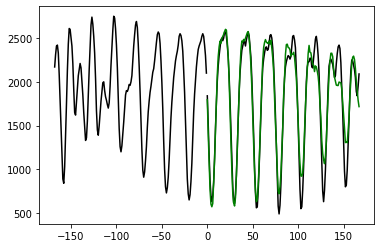

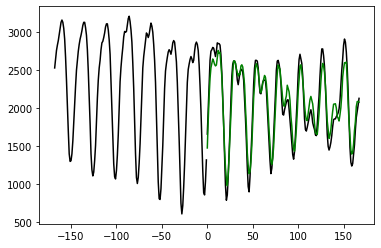

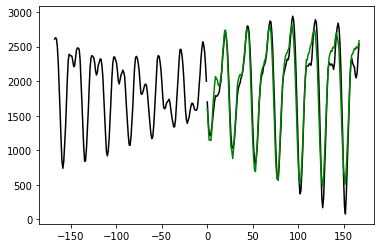

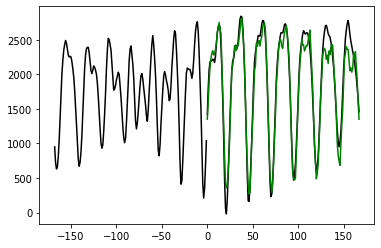

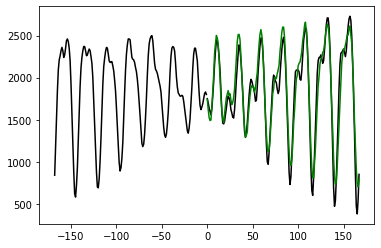

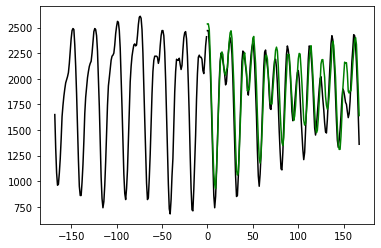

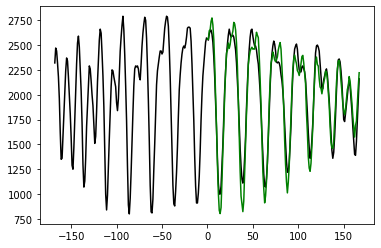

In [24]:
def plot_predictions(x_test=x_test, y_test=y_test, past=past_steps, future=future_steps, model=model, num_to_show=10, y_pos=y_position, maxes=maxes):
    y_pred = model.predict(x_test)[:, -1][..., np.newaxis]
    y_pred = y_pred*(maxes[y_pos])
    y_test = y_test*(maxes[y_pos])
    
    for i in range(len(maxes)):
        x_test[:,:,i] = x_test[:,:,i]*maxes[i]
    
    rng = np.random.default_rng()
    array = np.array(rng.integers(len(y_pred +1), size=num_to_show))
    for i in array:
        past_x = x_test[i,:,y_pos]
        future_x = y_test[i,(past-1),:]
        predictions = y_pred[i]
        
        future_x_axis = range(0, future)
        past_x_axis = range(-past, 0)
        plt.plot(past_x_axis, past_x, color='black')
        plt.plot(future_x_axis, future_x, color='black')
        plt.plot(future_x_axis, predictions, color ='green')
        plt.show()
    return y_pred
        
predictions = plot_predictions()